# POS Tagging - An Overview

The process of classifying words into their __parts of speech__ and labeling them accordingly is known as **part-of-speech tagging**, or simply **POS-tagging**.

The NLTK library has a number of corpora which contains word and its POS tag. 

# Notebook layout
1. Preprocess data
2. Vanilla RNN
3. Word Embeddings
4. LSTM
5. GRU
6. Bidirectional LSTM
7. Model Evaluation

In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 1. Preprocess data

## Load data

In [2]:
import nltk
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /home/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package brown to /home/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package conll2000 to /home/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package universal_tagset to /home/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [2]:
# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [3]:
type(treebank_corpus)

nltk.corpus.reader.util.ConcatenatedCorpusView

In [5]:
type(brown_corpus)

nltk.corpus.reader.util.ConcatenatedCorpusView

In [6]:
type(conll_corpus)

nltk.collections.LazyMap

In [7]:
len(treebank_corpus)

3914

In [8]:
len(brown_corpus)

57340

In [9]:
len(conll_corpus)

10948

In [10]:
conll2000

<ConllChunkCorpusReader in '/home/nltk_data/corpora/conll2000'>

In [11]:
brown

<CategorizedTaggedCorpusReader in '/home/nltk_data/corpora/brown'>

In [12]:
treebank

<BracketParseCorpusReader in '/home/nltk_data/corpora/treebank/combined'>

In [13]:
treebank_corpus

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], ...]

In [14]:
brown_corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [15]:
conll_corpus

[[('Confidence', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('pound', 'NOUN'), ('is', 'VERB'), ('widely', 'ADV'), ('expected', 'VERB'), ('to', 'PRT'), ('take', 'VERB'), ('another', 'DET'), ('sharp', 'ADJ'), ('dive', 'NOUN'), ('if', 'ADP'), ('trade', 'NOUN'), ('figures', 'NOUN'), ('for', 'ADP'), ('September', 'NOUN'), (',', '.'), ('due', 'ADJ'), ('for', 'ADP'), ('release', 'NOUN'), ('tomorrow', 'NOUN'), (',', '.'), ('fail', 'VERB'), ('to', 'PRT'), ('show', 'VERB'), ('a', 'DET'), ('substantial', 'ADJ'), ('improvement', 'NOUN'), ('from', 'ADP'), ('July', 'NOUN'), ('and', 'CONJ'), ('August', 'NOUN'), ("'s", 'PRT'), ('near-record', 'ADJ'), ('deficits', 'NOUN'), ('.', '.')], [('Chancellor', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Exchequer', 'NOUN'), ('Nigel', 'NOUN'), ('Lawson', 'NOUN'), ("'s", 'PRT'), ('restated', 'VERB'), ('commitment', 'NOUN'), ('to', 'PRT'), ('a', 'DET'), ('firm', 'NOUN'), ('monetary', 'ADJ'), ('policy', 'NOUN'), ('has', 'VERB'), ('helped', 'VERB'), ('to', 'PRT'), ('prev

In [16]:
# let's look at the data
tagged_sentences[11]

[('``', '.'),
 ('We', 'PRON'),
 ('have', 'VERB'),
 ('no', 'DET'),
 ('useful', 'ADJ'),
 ('information', 'NOUN'),
 ('on', 'ADP'),
 ('whether', 'ADP'),
 ('users', 'NOUN'),
 ('are', 'VERB'),
 ('at', 'ADP'),
 ('risk', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('James', 'NOUN'),
 ('A.', 'NOUN'),
 ('Talcott', 'NOUN'),
 ('of', 'ADP'),
 ('Boston', 'NOUN'),
 ("'s", 'PRT'),
 ('Dana-Farber', 'NOUN'),
 ('Cancer', 'NOUN'),
 ('Institute', 'NOUN'),
 ('.', '.')]

In [17]:
type(tagged_sentences)

nltk.collections.LazyConcatenation

In [4]:
len(tagged_sentences)

72202

## Divide data in words (X) and tags (Y)

Since this is a **many-to-many** problem, each data point will be a different sentence of the corpora.

Each data point will have multiple words in the **input sequence**. This is what we will refer to as **X**.

Each word will have its correpsonding tag in the **output sequence**. This what we will refer to as **Y**.

Sample dataset:

|                    X                        |                 Y                |
|---------------------------------------------|----------------------------------|
|   Mr. Vinken is chairman of Elsevier        |   NOUN NOUN VERB NOUN ADP NOUN   |
|     We have no useful information           |      PRON VERB DET ADJ NOUN      |

In [7]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [8]:
type(X), type(X_sentence)

(list, list)

In [9]:
len(X), len(X_sentence)

(72202, 28)

In [10]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [11]:
num_words, num_tags

(59448, 12)

In [12]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [13]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [14]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 18
Length of first output sequence : 18


## Vectorise X and Y

#### Encode X and Y to integer values

We'll use the Tokenizer() function from Keras library to encode text sequence to integer sequence

In [15]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [16]:
(X_encoded[1])

[72, 24231, 11, 454, 4, 32828, 19723, 2, 1, 4782, 3119, 186, 3]

In [17]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [30]:
len(Y_encoded[1])

13

In [18]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [19]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


## Pad sequences

The next step after encoding the data is to **define the sequence lengths**. As of now, the sentences present in the data are of various lengths. We need to either pad short sentences or truncate long sentences to a fixed length. This fixed length, however, is a **hyperparameter**.

In [20]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


In [21]:
len(lengths)

72202

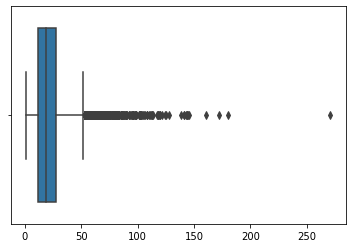

In [22]:
sns.boxplot(lengths)
plt.show()

In [23]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [24]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


RNN will learn the zero to zero mapping while training. So we don't need to worry about the padded zeroes. Please note that zero is not reserved for any word or tag, it's only reserved for padding.

In [25]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

## Word embeddings

Currently, each word and each tag is encoded as an integer. 

We'll use a more sophisticated technique to represent the input words (X) using what's known as **word embeddings**.

However, to represent each tag in Y, we'll simply use **one-hot encoding** scheme since there are only 13 tags in the dataset and the LSTM will have no problems in learning its own representation of these tags.

To use word embeddings, you can go for either of the following models:
1. word2vec model: https://code.google.com/archive/p/word2vec/
2. GloVe model : https://nlp.stanford.edu/projects/glove/

We're using the word2vec model for no particular reason. Both of these are very efficient in representing words. You can try both and see which one works better.

Dimensions of a word embedding is: (VOCABULARY_SIZE, EMBEDDING_DIMENSION)

### Use word embeddings for input sequences (X)

In [26]:
# word2vec download link (Size ~ 1.5GB): https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

path = '/home/datasets/GoogleNews-vectors-negative300.bin'

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [27]:
# word2vec effectiveness
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929387867450714),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.4422132968902588),
 ('Jackson', 0.440250426530838),
 ('NECN_Alison', 0.4331282675266266),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [28]:
# word2vec effectiveness
word2vec.most_similar(positive = ["King"])

[('Jackson', 0.5326348543167114),
 ('Prince', 0.5306329727172852),
 ('Tupou_V.', 0.5292826294898987),
 ('KIng', 0.5227501392364502),
 ('e_mail_robert.king_@', 0.5173623561859131),
 ('king', 0.5158917903900146),
 ('Queen', 0.5157250165939331),
 ('Geoffrey_Rush_Exit', 0.49920955300331116),
 ('prosecutor_Dan_Satterberg', 0.49850785732269287),
 ('NECN_Alison', 0.49128594994544983)]

In [29]:
len(word_tokenizer.word_index)

59448

In [30]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [31]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [32]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

### Use one-hot encoding for output sequences (Y)

In [33]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [34]:
# print Y of the first output sequqnce
print(Y.shape)

(72202, 100, 13)


## Split data in training, validation and tesing sets

In [35]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [36]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [37]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


Before using RNN, we must make sure the dimensions of the data are what an RNN expects. In general, an RNN expects the following shape

Shape of X:
(#samples, #timesteps, #features)

Shape of Y:
(#samples, #timesteps, #features)

![RNN tensor shape](./jupyter resources/rnn_tensor.png)

Now, there can be various variations in the shape that you use to feed an RNN depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That's because when you use the Embedding() layer in Keras, you the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimention (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which is what we have done. However, note that you'll need to shape it to (#samples, #timesteps, #features) in case you don't use the Embedding() layer in Keras.

# 2. Vanilla RNN

### Uninitialised fixed embeddings
First let's try running a vanilla RNN. For this RNN we won't use the pre-trained word embeddings. We'll use randomly inititalised embeddings. Moreover, we won't update the embeddings weights.

In [38]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [126]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [127]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [128]:
# check summary of the model
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


## Fit model

In [129]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 32s 75ms/step - loss: 0.5051 - acc: 0.8544 - val_loss: 0.3485 - val_acc: 0.8963
Epoch 2/10
408/408 [==============================] - 31s 77ms/step - loss: 0.2891 - acc: 0.9115 - val_loss: 0.2418 - val_acc: 0.9247
Epoch 3/10
408/408 [==============================] - 32s 78ms/step - loss: 0.2173 - acc: 0.9318 - val_loss: 0.1944 - val_acc: 0.9380
Epoch 4/10
408/408 [==============================] - 31s 77ms/step - loss: 0.1813 - acc: 0.9417 - val_loss: 0.1673 - val_acc: 0.9459
Epoch 5/10
408/408 [==============================] - 32s 78ms/step - loss: 0.1594 - acc: 0.9485 - val_loss: 0.1505 - val_acc: 0.9514
Epoch 6/10
408/408 [==============================] - 31s 77ms/step - loss: 0.1461 - acc: 0.9525 - val_loss: 0.1405 - val_acc: 0.9542
Epoch 7/10
408/408 [==============================] - 32s 78ms/step - loss: 0.1378 - acc: 0.9548 - val_loss: 0.1339 - val_acc: 0.9561
Epoch 8/10
408/408 [==============================] - 32s 78ms

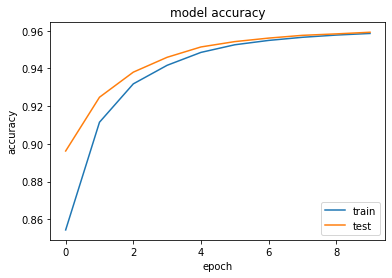

In [131]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [149]:
X_validation[1][-20:], np.argmax(Y_validation[1][-20:], axis = -1)

(array([   0,    0,    0,    0,  143,    4,   84, 1548, 2297,  310,   23,
         310,  188,  111, 9323, 2609,  141,  334,  657,    3], dtype=int32),
 array([0, 0, 0, 0, 5, 4, 5, 1, 2, 1, 4, 1, 4, 6, 6, 1, 4, 6, 1, 3]))

In [150]:
y_pred = rnn_model.predict(X_validation[1:2])

In [151]:
y_pred[0].shape

(100, 13)

In [153]:
print(np.argmax(y_pred[0][-20:],axis =1))

[0 0 0 0 5 4 5 1 1 2 4 1 4 1 1 1 4 1 1 3]


In [183]:
print(accuracy_score(([0, 0, 0, 0, 5, 4, 5, 1, 2, 1, 4, 1, 4, 6, 6, 1, 4, 6, 1, 3]), ([0, 0, 0, 0, 5, 4, 5, 1, 1, 2, 4, 1, 4, 1, 1, 1, 4, 1, 1, 3])))

0.75


In [154]:
X_test[1][-20:], np.argmax(Y_test[1][-20:], axis= 1)

(array([   0,    0,    0,    0,    0,    0,    0,   43,  171,   15,    5,
         824,  479, 1888, 1310,  135,   15,  870,   14,    3], dtype=int32),
 array([ 0,  0,  0,  0,  0,  0,  0,  8,  2,  8,  9, 10,  2,  1,  7,  7,  8,
         2,  3,  3]))

In [155]:
y_pred = rnn_model.predict(X_test[1:2])

In [156]:
y_pred[0].shape

(100, 13)

In [157]:
print(np.argmax(y_pred[0][-20:],axis =1))

[0 0 0 0 0 0 0 8 2 8 9 4 2 1 2 7 8 2 3 3]


In [184]:
print(accuracy_score([ 0,  0,  0,  0,  0,  0,  0,  8,  2,  8,  9, 10,  2,  1,  7,  7,  8,
         2,  3,  3], [0, 0, 0, 0, 0, 0, 0, 8, 2, 8, 9, 4, 2, 1, 2, 7, 8, 2, 3, 3]))

0.9


### Uninitialised trainable embeddings

In [158]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [159]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [160]:
# check summary of the model
rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [161]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 32s 76ms/step - loss: 0.2175 - acc: 0.9475 - val_loss: 0.0422 - val_acc: 0.9875
Epoch 2/10
408/408 [==============================] - 31s 75ms/step - loss: 0.0305 - acc: 0.9902 - val_loss: 0.0298 - val_acc: 0.9899
Epoch 3/10
408/408 [==============================] - 31s 75ms/step - loss: 0.0213 - acc: 0.9926 - val_loss: 0.0274 - val_acc: 0.9902
Epoch 4/10
408/408 [==============================] - 31s 76ms/step - loss: 0.0177 - acc: 0.9937 - val_loss: 0.0270 - val_acc: 0.9905
Epoch 5/10
408/408 [==============================] - 31s 75ms/step - loss: 0.0154 - acc: 0.9945 - val_loss: 0.0271 - val_acc: 0.9905
Epoch 6/10
408/408 [==============================] - 31s 75ms/step - loss: 0.0134 - acc: 0.9953 - val_loss: 0.0278 - val_acc: 0.9905
Epoch 7/10
408/408 [==============================] - 31s 75ms/step - loss: 0.0116 - acc: 0.9960 - val_loss: 0.0289 - val_acc: 0.9904
Epoch 8/10
408/408 [==============================] - 30s 75ms

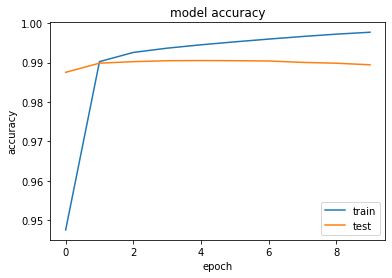

In [162]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [173]:
from sklearn.metrics import accuracy_score

In [166]:
X_validation[1][-20:], np.argmax(Y_validation[1][-20:], axis = -1)

(array([   0,    0,    0,    0,  143,    4,   84, 1548, 2297,  310,   23,
         310,  188,  111, 9323, 2609,  141,  334,  657,    3], dtype=int32),
 array([0, 0, 0, 0, 5, 4, 5, 1, 2, 1, 4, 1, 4, 6, 6, 1, 4, 6, 1, 3]))

In [167]:
y_pred = rnn_model.predict(X_validation[1:2])

In [168]:
y_pred[0].shape

(100, 13)

In [169]:
print(np.argmax(y_pred[0][-20:],axis =1))

[0 0 0 0 5 4 5 1 2 1 4 1 4 6 6 1 4 6 1 3]


In [174]:
print(accuracy_score(np.argmax(Y_validation[1][-20:], axis = -1), (np.argmax(y_pred[0][-20:],axis =1))))

1.0


In [175]:
X_test[1][-20:], np.argmax(Y_test[1][-20:], axis= 1)

(array([   0,    0,    0,    0,    0,    0,    0,   43,  171,   15,    5,
         824,  479, 1888, 1310,  135,   15,  870,   14,    3], dtype=int32),
 array([ 0,  0,  0,  0,  0,  0,  0,  8,  2,  8,  9, 10,  2,  1,  7,  7,  8,
         2,  3,  3]))

In [176]:
y_pred = rnn_model.predict(X_test[1:2])

In [177]:
y_pred[0].shape

(100, 13)

In [178]:
print(np.argmax(y_pred[0][-20:],axis =1))

[ 0  0  0  0  0  0  0  8  2  8  9 10  2  1  7  7  8  2  3  3]


In [180]:
print(accuracy_score(np.argmax(Y_test[1][-20:], axis= 1), (np.argmax(y_pred[0][-20:],axis =1))))

1.0


### Using pre-trained embedding weights

In [111]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [112]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [113]:
# check summary of the model
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [114]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 32s 76ms/step - loss: 0.1841 - acc: 0.9610 - val_loss: 0.0356 - val_acc: 0.9890
Epoch 2/10
408/408 [==============================] - 31s 76ms/step - loss: 0.0271 - acc: 0.9910 - val_loss: 0.0275 - val_acc: 0.9905
Epoch 3/10
408/408 [==============================] - 31s 75ms/step - loss: 0.0200 - acc: 0.9929 - val_loss: 0.0258 - val_acc: 0.9909
Epoch 4/10
408/408 [==============================] - 31s 76ms/step - loss: 0.0171 - acc: 0.9939 - val_loss: 0.0252 - val_acc: 0.9910
Epoch 5/10
408/408 [==============================] - 31s 76ms/step - loss: 0.0150 - acc: 0.9946 - val_loss: 0.0252 - val_acc: 0.9911
Epoch 6/10
408/408 [==============================] - 31s 76ms/step - loss: 0.0134 - acc: 0.9952 - val_loss: 0.0256 - val_acc: 0.9911
Epoch 7/10
408/408 [==============================] - 31s 76ms/step - loss: 0.0118 - acc: 0.9958 - val_loss: 0.0265 - val_acc: 0.9910
Epoch 8/10
408/408 [==============================] - 31s 75ms

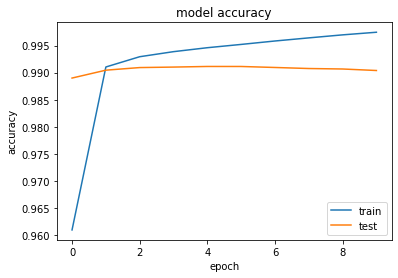

In [115]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [116]:
X_validation[0], Y_validation[0][-7:]

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  43, 876, 803,  15,   2, 224,   3], dtype=int32),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

In [117]:
y_pred = rnn_model.predict(X_validation[0:1])

In [118]:
y_pred[0].shape

(100, 13)

In [119]:
print(np.argmax(y_pred[0],axis =1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 2 2 8 3 7 3]


In [125]:
X_test[0], Y_test[0][-16:]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   26,   98,   16,
        1391,   83, 2009,    2,   41,    8, 3870,    5,   41,    8, 9198,
           3], dtype=int32),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [121]:
y_pred = rnn_model.predict(X_test[0:1])

In [122]:
y_pred[0].shape

(100, 13)

In [123]:
print(np.argmax(y_pred[0],axis =1))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  5  1  8  2 11  1  3 11  4  1  9
 11  4  1  3]


# 2. LSTM

We'll use pre-trained word embeddings in following models and allow them to be updated as well. 

## Create model architecture

In [186]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [187]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [188]:
# check summary of the model
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           93440     
                                                                 
 time_distributed_6 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,928,985
Trainable params: 17,928,985
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [189]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10


2022-11-22 13:28:32.768866: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


408/408 [==============================] - 9s 17ms/step - loss: 0.3072 - acc: 0.9309 - val_loss: 0.0488 - val_acc: 0.9866
Epoch 2/10
408/408 [==============================] - 6s 15ms/step - loss: 0.0348 - acc: 0.9893 - val_loss: 0.0307 - val_acc: 0.9897
Epoch 3/10
408/408 [==============================] - 6s 16ms/step - loss: 0.0244 - acc: 0.9914 - val_loss: 0.0270 - val_acc: 0.9903
Epoch 4/10
408/408 [==============================] - 6s 16ms/step - loss: 0.0206 - acc: 0.9925 - val_loss: 0.0252 - val_acc: 0.9910
Epoch 5/10
408/408 [==============================] - 6s 16ms/step - loss: 0.0183 - acc: 0.9933 - val_loss: 0.0246 - val_acc: 0.9912
Epoch 6/10
408/408 [==============================] - 6s 16ms/step - loss: 0.0166 - acc: 0.9939 - val_loss: 0.0242 - val_acc: 0.9914
Epoch 7/10
408/408 [==============================] - 6s 16ms/step - loss: 0.0151 - acc: 0.9944 - val_loss: 0.0239 - val_acc: 0.9916
Epoch 8/10
408/408 [==============================] - 6s 16ms/step - loss: 0.013

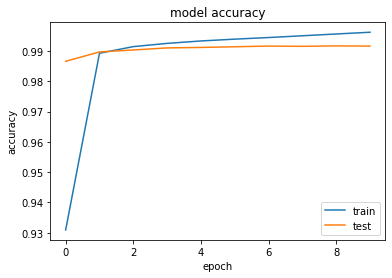

In [190]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [195]:
X_validation[1][-20:], np.argmax(Y_validation[1][-20:], axis = -1)

(array([   0,    0,    0,    0,  143,    4,   84, 1548, 2297,  310,   23,
         310,  188,  111, 9323, 2609,  141,  334,  657,    3], dtype=int32),
 array([0, 0, 0, 0, 5, 4, 5, 1, 2, 1, 4, 1, 4, 6, 6, 1, 4, 6, 1, 3]))

In [196]:
y_pred = lstm_model.predict(X_validation[1:2])

In [197]:
y_pred[0].shape

(100, 13)

In [198]:
print(np.argmax(y_pred[0][-20:],axis =1))

[0 0 0 0 5 4 5 1 2 1 4 1 4 6 6 1 4 6 1 3]


In [199]:
print(accuracy_score(np.argmax(Y_validation[1][-20:], axis = -1), (np.argmax(y_pred[0][-20:],axis =1))))

1.0


In [200]:
X_test[1][-20:], np.argmax(Y_test[1][-20:], axis= 1)

(array([   0,    0,    0,    0,    0,    0,    0,   43,  171,   15,    5,
         824,  479, 1888, 1310,  135,   15,  870,   14,    3], dtype=int32),
 array([ 0,  0,  0,  0,  0,  0,  0,  8,  2,  8,  9, 10,  2,  1,  7,  7,  8,
         2,  3,  3]))

In [201]:
y_pred = lstm_model.predict(X_test[1:2])

In [202]:
y_pred[0].shape

(100, 13)

In [203]:
print(np.argmax(y_pred[0][-20:],axis =1))

[ 0  0  0  0  0  0  0  8  2  8  9 10  2  1  7  7  8  2  3  3]


In [204]:
print(accuracy_score(np.argmax(Y_test[1][-20:], axis= 1), (np.argmax(y_pred[0][-20:],axis =1))))

1.0


# 2. GRU

## Create model architecture

In [205]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [206]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [207]:
# check summary of model
gru_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_7 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,905,817
Trainable params: 17,905,817
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [208]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 8s 16ms/step - loss: 0.2207 - acc: 0.9595 - val_loss: 0.0348 - val_acc: 0.9885
Epoch 2/10
408/408 [==============================] - 6s 15ms/step - loss: 0.0272 - acc: 0.9905 - val_loss: 0.0269 - val_acc: 0.9904
Epoch 3/10
408/408 [==============================] - 6s 15ms/step - loss: 0.0207 - acc: 0.9924 - val_loss: 0.0248 - val_acc: 0.9909
Epoch 4/10
408/408 [==============================] - 6s 15ms/step - loss: 0.0179 - acc: 0.9933 - val_loss: 0.0239 - val_acc: 0.9913
Epoch 5/10
408/408 [==============================] - 6s 15ms/step - loss: 0.0162 - acc: 0.9940 - val_loss: 0.0237 - val_acc: 0.9914
Epoch 6/10
408/408 [==============================] - 6s 15ms/step - loss: 0.0148 - acc: 0.9944 - val_loss: 0.0238 - val_acc: 0.9915
Epoch 7/10
408/408 [==============================] - 6s 15ms/step - loss: 0.0136 - acc: 0.9949 - val_loss: 0.0240 - val_acc: 0.9915
Epoch 8/10
408/408 [==============================] - 6s 15ms/step - 

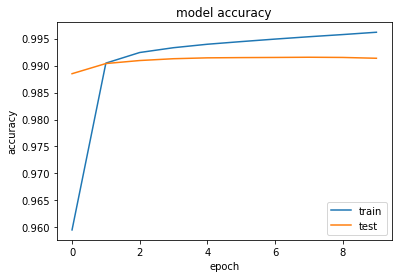

In [209]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [210]:
X_validation[1][-20:], np.argmax(Y_validation[1][-20:], axis = -1)

(array([   0,    0,    0,    0,  143,    4,   84, 1548, 2297,  310,   23,
         310,  188,  111, 9323, 2609,  141,  334,  657,    3], dtype=int32),
 array([0, 0, 0, 0, 5, 4, 5, 1, 2, 1, 4, 1, 4, 6, 6, 1, 4, 6, 1, 3]))

In [211]:
y_pred = gru_model.predict(X_validation[1:2])

In [212]:
y_pred[0].shape

(100, 13)

In [213]:
print(np.argmax(y_pred[0][-20:],axis =1))

[0 0 0 0 5 4 5 1 2 1 4 1 4 6 6 1 4 6 1 3]


In [214]:
print(accuracy_score(np.argmax(Y_validation[1][-20:], axis = -1), (np.argmax(y_pred[0][-20:],axis =1))))

1.0


In [215]:
X_test[1][-20:], np.argmax(Y_test[1][-20:], axis= 1)

(array([   0,    0,    0,    0,    0,    0,    0,   43,  171,   15,    5,
         824,  479, 1888, 1310,  135,   15,  870,   14,    3], dtype=int32),
 array([ 0,  0,  0,  0,  0,  0,  0,  8,  2,  8,  9, 10,  2,  1,  7,  7,  8,
         2,  3,  3]))

In [216]:
y_pred = gru_model.predict(X_test[1:2])

In [217]:
y_pred[0].shape

(100, 13)

In [218]:
print(np.argmax(y_pred[0][-20:],axis =1))

[ 0  0  0  0  0  0  0  8  2  8  9 10  2  1  7  7  8  2  3  3]


In [219]:
print(accuracy_score(np.argmax(Y_test[1][-20:], axis= 1), (np.argmax(y_pred[0][-20:],axis =1))))

1.0


# 3. Bidirectional LSTM

## Create model architecture

In [220]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [221]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [222]:
# check summary of model
bidirect_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_8 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 18,023,257
Trainable params: 18,023,257
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [223]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 12s 25ms/step - loss: 0.2416 - acc: 0.9412 - val_loss: 0.0325 - val_acc: 0.9898
Epoch 2/10
408/408 [==============================] - 9s 22ms/step - loss: 0.0237 - acc: 0.9923 - val_loss: 0.0220 - val_acc: 0.9926
Epoch 3/10
408/408 [==============================] - 9s 22ms/step - loss: 0.0161 - acc: 0.9946 - val_loss: 0.0195 - val_acc: 0.9933
Epoch 4/10
408/408 [==============================] - 9s 23ms/step - loss: 0.0128 - acc: 0.9957 - val_loss: 0.0182 - val_acc: 0.9938
Epoch 5/10
408/408 [==============================] - 9s 22ms/step - loss: 0.0105 - acc: 0.9965 - val_loss: 0.0179 - val_acc: 0.9940
Epoch 6/10
408/408 [==============================] - 9s 23ms/step - loss: 0.0086 - acc: 0.9972 - val_loss: 0.0179 - val_acc: 0.9941
Epoch 7/10
408/408 [==============================] - 9s 22ms/step - loss: 0.0069 - acc: 0.9978 - val_loss: 0.0181 - val_acc: 0.9941
Epoch 8/10
408/408 [==============================] - 9s 22ms/step -

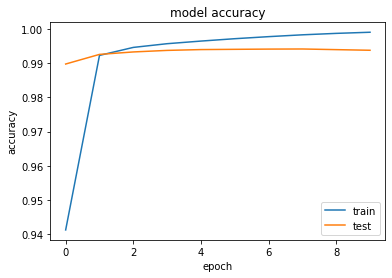

In [224]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# 5. Model evaluation

In [225]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 6s 19ms/step - loss: 0.0352 - acc: 0.9895
Loss: 0.03522904962301254,
Accuracy: 0.9895125031471252


In [226]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 2s 6ms/step - loss: 0.0253 - acc: 0.9916
Loss: 0.025254443287849426,
Accuracy: 0.9915871024131775


In [227]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 2s 5ms/step - loss: 0.0257 - acc: 0.9915
Loss: 0.025746488943696022,
Accuracy: 0.9915012717247009


In [228]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 3s 8ms/step - loss: 0.0223 - acc: 0.9937
Loss: 0.022310379892587662,
Accuracy: 0.9937208294868469
